In [2]:
pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 7.7 MB/s 
     |████████████████████████████████| 18.0 MB 45.5 MB/s 
     |████████████████████████████████| 240 kB 57.8 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 112 kB 71.0 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 37.5 MB 47 kB/s 
     |████████████████████████████████| 943 kB 59.1 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
     |████████████████████████████████| 1.6 MB 41.2 MB/s 
     |████████████████████████████████| 4.1 MB 38.3 MB/s 
     |████████████████████████████████| 112 kB 55.1 MB/s 
  Created wheel for qiskit: filename=qiskit-0.37.0-py3-none-any.whl size=12028 sha256=9c73867eddbec3cb88ad75b41a11420b9ff1c9626e1d13043fe5fcae0f428e65
  S

In [3]:
pip install qiskit_finance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 159 kB 12.1 MB/s 
     |████████████████████████████████| 610 kB 57.0 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 6.4 MB 44.8 MB/s 
  Created wheel for docplex: filename=docplex-2.23.222-py3-none-any.whl size=662847 sha256=b9b72823fe5f66985f0077dcafc6155e8548e5ab7b28e9fcad5b3bd23ab3ff3d
  Stored in directory: /root/.cache/pip/wheels/a7/c9/fb/cee5a89f304e77a39c466e625ac2830434b76eb8384999d116
Successfully built docplex
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's depen

In [4]:
#importing the required stuff

from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [5]:
%matplotlib inline
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import *
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()


In [6]:
# set number of assets (= number of qubits)
num_assets = 4
seed = 1234

# Generate expected return and covariance matrix from (random) time-series
#stocks = [("TICKER%s" % i) for i in range(num_assets)]
# data = RandomDataProvider(
#     tickers=stocks,
#     start=datetime.datetime(2016, 1, 1),
#     end=datetime.datetime(2016, 1, 30),
#     seed=seed,
# )



#### Using data from yahoo finance
data = YahooDataProvider(
        tickers=["PINS","TWTR","META","SNAP"],
        start=datetime.datetime(2019, 9, 1),
        end=datetime.datetime(2021, 12, 1),
    )
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


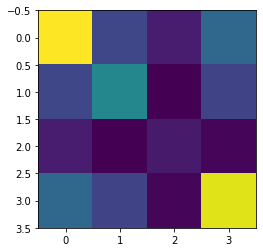

In [7]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()


In [8]:
q = 0.5  # set risk factor
budget = num_assets // 4  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.0009539800972263747*x_0^2 + 0.000747755863371199..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [9]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))


In [10]:

#classical reference solution

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 0. 0. 1.], value -0.0019

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 0 0 1]	-0.0019		1.0000
 [1 1 1 1]	9.1135		0.0000
 [0 1 1 1]	4.0488		0.0000
 [1 0 1 1]	4.0489		0.0000
 [0 0 1 1]	1.0101		0.0000
 [1 1 0 1]	4.0503		0.0000
 [0 1 0 1]	1.0113		0.0000
 [1 0 0 1]	1.0113		0.0000
 [1 1 1 0]	4.0505		0.0000
 [0 1 1 0]	1.0119		0.0000
 [1 0 1 0]	1.0118		0.0000
 [0 0 1 0]	-0.0010		0.0000
 [1 1 0 0]	1.0129		0.0000
 [0 1 0 0]	-0.0001		0.0000
 [1 0 0 0]	-0.0003		0.0000
 [0 0 0 0]	1.0125		0.0000


In [11]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [0. 0. 0. 1.], value -0.0019

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	-0.0001		0.8609
 [0 0 0 1]	-0.0019		0.1345
 [1 0 0 0]	-0.0003		0.0046
 [0 1 0 1]	1.0113		0.0000
 [0 0 1 0]	-0.0010		0.0000
 [0 1 1 0]	1.0119		0.0000
 [1 1 0 0]	1.0129		0.0000
 [1 0 1 1]	4.0489		0.0000
 [1 0 1 0]	1.0118		0.0000
 [0 0 1 1]	1.0101		0.0000
 [1 1 1 0]	4.0505		0.0000
 [0 0 0 0]	1.0125		0.0000
 [1 1 0 1]	4.0503		0.0000
 [1 1 1 1]	9.1135		0.0000
 [0 1 1 1]	4.0488		0.0000
 [1 0 0 1]	1.0113		0.0000


In [12]:
##VQE SOln
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)


Optimal: selection [0. 0. 0. 1.], value -0.0019

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	-0.0001		0.8609
 [0 0 0 1]	-0.0019		0.1345
 [1 0 0 0]	-0.0003		0.0046
 [0 1 0 1]	1.0113		0.0000
 [0 0 1 0]	-0.0010		0.0000
 [0 1 1 0]	1.0119		0.0000
 [1 1 0 0]	1.0129		0.0000
 [1 0 1 1]	4.0489		0.0000
 [1 0 1 0]	1.0118		0.0000
 [0 0 1 1]	1.0101		0.0000
 [1 1 1 0]	4.0505		0.0000
 [0 0 0 0]	1.0125		0.0000
 [1 1 0 1]	4.0503		0.0000
 [1 1 1 1]	9.1135		0.0000
 [0 1 1 1]	4.0488		0.0000
 [1 0 0 1]	1.0113		0.0000


In [13]:
#### QAOA solution

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)


Optimal: selection [0. 0. 0. 1.], value -0.0019

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	-0.0001		0.1735
 [1 0 0 0]	-0.0003		0.1735
 [0 0 1 0]	-0.0010		0.1734
 [0 0 0 1]	-0.0019		0.1732
 [0 0 0 0]	1.0125		0.1281
 [0 0 1 1]	1.0101		0.0279
 [1 0 0 1]	1.0113		0.0274
 [0 1 0 1]	1.0113		0.0274
 [1 0 1 0]	1.0118		0.0271
 [0 1 1 0]	1.0119		0.0271
 [1 1 0 0]	1.0129		0.0266
 [1 1 1 1]	9.1135		0.0070
 [1 1 1 0]	4.0505		0.0020
 [1 1 0 1]	4.0503		0.0020
 [1 0 1 1]	4.0489		0.0019
 [0 1 1 1]	4.0488		0.0019


In [14]:
stocks = ["PINS","TWTR","META","SNAP"]

token = "NBQ7j3g_Q8_bcpvW6kMA"
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    try:
        wiki = WikipediaDataProvider(
            token=token,
            tickers=stocks,
            start=datetime.datetime(2016, 9, 1),
            end=datetime.datetime(2021, 12, 30),
        )
        wiki.run()
    except QiskitFinanceError as ex:
        print(ex)
        print("Error retrieving data.")


In [15]:
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        if wiki._n <= 1:
            print(
                "Not enough wiki data to plot covariance or time-series similarity. Please use at least two tickers."
            )
        else:
            rho = wiki.get_similarity_matrix()
            print("A time-series similarity measure:")
            print(rho)
            plt.imshow(rho)
            plt.show()

            cov = wiki.get_covariance_matrix()
            print("A covariance matrix:")
            print(cov)
            plt.imshow(cov)
            plt.show()
    else:
        print("No wiki data loaded.")


In [16]:
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        print("The underlying evolution of stock prices:")
        for (cnt, s) in enumerate(stocks):
            plt.plot(wiki._data[cnt], label=s)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

        for (cnt, s) in enumerate(stocks):
            print(s)
            print(wiki._data[cnt])
    else:
        print("No wiki data loaded.")


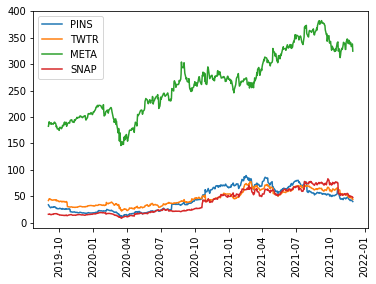

In [17]:
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()


In [18]:
for (cnt, s) in enumerate(data._tickers):
    print(data._data[cnt])

Date
2019-09-03    33.810001
2019-09-04    32.619999
2019-09-05    31.260000
2019-09-06    30.360001
2019-09-09    28.200001
                ...    
2021-11-23    41.770000
2021-11-24    42.340000
2021-11-26    42.799999
2021-11-29    40.540001
2021-11-30    40.060001
Name: Adj Close, Length: 567, dtype: float64
Date
2019-09-03    41.959999
2019-09-04    43.360001
2019-09-05    45.299999
2019-09-06    45.419998
2019-09-09    44.259998
                ...    
2021-11-23    47.139999
2021-11-24    47.520000
2021-11-26    47.070000
2021-11-29    45.779999
2021-11-30    43.939999
Name: Adj Close, Length: 567, dtype: float64
Date
2019-09-03    182.389999
2019-09-04    187.139999
2019-09-05    190.899994
2019-09-06    187.490005
2019-09-09    188.759995
                 ...    
2021-11-23    337.250000
2021-11-24    341.059998
2021-11-26    333.119995
2021-11-29    338.029999
2021-11-30    324.459991
Name: Adj Close, Length: 567, dtype: float64
Date
2019-09-03    15.930000
2019-09-04    15.8

Automotive

---


In [19]:
# set number of assets (= number of qubits)
num_assets = 4
seed = 1234

# Generate expected return and covariance matrix from (random) time-series
#stocks = [("TICKER%s" % i) for i in range(num_assets)]
# data = RandomDataProvider(
#     tickers=stocks,
#     start=datetime.datetime(2016, 1, 1),
#     end=datetime.datetime(2016, 1, 30),
#     seed=seed,
# )



#### Using data from yahoo finance
data = YahooDataProvider(
        tickers=["GM","DMLRY","TSLA","F"],
        start=datetime.datetime(2016, 9, 1),
        end=datetime.datetime(2021, 12, 1),
    )
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


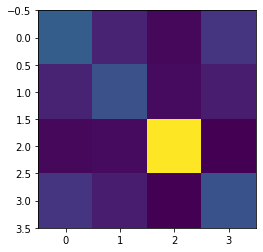

In [20]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [21]:
q = 0.5  # set risk factor
budget = num_assets // 4  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.00027820443997866276*x_0^2 + 0.00032369894017474..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [22]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [23]:

#classical reference solution

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 0. 1. 0.], value -0.0025

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 0 1 0]	-0.0025		1.0000
 [1 1 1 1]	9.0757		0.0000
 [0 1 1 1]	4.0320		0.0000
 [1 0 1 1]	4.0319		0.0000
 [0 0 1 1]	1.0058		0.0000
 [1 1 0 1]	4.0342		0.0000
 [0 1 0 1]	1.0081		0.0000
 [1 0 0 1]	1.0080		0.0000
 [0 0 0 1]	-0.0005		0.0000
 [1 1 1 0]	4.0320		0.0000
 [0 1 1 0]	1.0060		0.0000
 [1 0 1 0]	1.0058		0.0000
 [1 1 0 0]	1.0080		0.0000
 [0 1 0 0]	-0.0004		0.0000
 [1 0 0 0]	-0.0006		0.0000
 [0 0 0 0]	1.0087		0.0000


In [24]:
##VQE SOln
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)


Optimal: selection [1. 0. 0. 0.], value -0.0006

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	-0.0004		0.8708
 [0 0 0 1]	-0.0005		0.1258
 [1 0 0 0]	-0.0006		0.0034
 [0 0 1 0]	-0.0025		0.0000
 [1 0 1 1]	4.0319		0.0000
 [1 0 1 0]	1.0058		0.0000
 [1 1 1 0]	4.0320		0.0000
 [0 0 1 1]	1.0058		0.0000
 [1 1 1 1]	9.0757		0.0000
 [0 1 0 1]	1.0081		0.0000
 [1 0 0 1]	1.0080		0.0000
 [1 1 0 0]	1.0080		0.0000
 [0 1 1 1]	4.0320		0.0000
 [0 0 0 0]	1.0087		0.0000
 [0 1 1 0]	1.0060		0.0000
 [1 1 0 1]	4.0342		0.0000


In [25]:
#### QAOA solution

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)


Optimal: selection [0. 0. 1. 0.], value -0.0025

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	-0.0004		0.1962
 [0 0 0 1]	-0.0005		0.1961
 [1 0 0 0]	-0.0006		0.1961
 [0 0 1 0]	-0.0025		0.1945
 [0 0 0 0]	1.0087		0.1155
 [0 1 0 1]	1.0081		0.0169
 [1 1 0 0]	1.0080		0.0169
 [1 0 0 1]	1.0080		0.0169
 [0 1 1 0]	1.0060		0.0162
 [0 0 1 1]	1.0058		0.0162
 [1 0 1 0]	1.0058		0.0161
 [1 1 0 1]	4.0342		0.0005
 [0 1 1 1]	4.0320		0.0005
 [1 1 1 0]	4.0320		0.0005
 [1 0 1 1]	4.0319		0.0005
 [1 1 1 1]	9.0757		0.0004


In [26]:
stocks = ["GM","DMLRY","TSLA","F"]

token = "NBQ7j3g_Q8_bcpvW6kMA"
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    try:
        wiki = WikipediaDataProvider(
            token=token,
            tickers=stocks,
            start=datetime.datetime(2016, 1, 1),
            end=datetime.datetime(2021, 12, 30),
        )
        wiki.run()
    except QiskitFinanceError as ex:
        print(ex)
        print("Error retrieving data.")


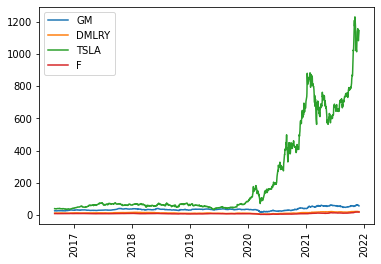

In [27]:
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [28]:
for (cnt, s) in enumerate(data._tickers):
    print(data._data[cnt])

Date
2016-09-01    27.191135
2016-09-02    27.498960
2016-09-06    27.464754
2016-09-07    27.594551
2016-09-08    27.438797
                ...    
2021-11-23    63.049999
2021-11-24    62.189999
2021-11-26    60.169998
2021-11-29    59.860001
2021-11-30    57.869999
Name: Adj Close, Length: 1321, dtype: float64
Date
2016-09-01    12.947559
2016-09-02    13.143821
2016-09-06    13.323258
2016-09-07    13.474657
2016-09-08    13.414845
                ...    
2021-11-23    23.336035
2021-11-24    22.783484
2021-11-26    21.595503
2021-11-29    21.549456
2021-11-30    21.678385
Name: Adj Close, Length: 1321, dtype: float64
Date
2016-09-01      40.153999
2016-09-02      39.556000
2016-09-06      40.566002
2016-09-07      40.341999
2016-09-08      39.472000
                 ...     
2021-11-23    1109.030029
2021-11-24    1116.000000
2021-11-26    1081.920044
2021-11-29    1136.989990
2021-11-30    1144.760010
Name: Adj Close, Length: 1321, dtype: float64
Date
2016-09-01     9.842530
2016

Mobiles

---



In [29]:
# set number of assets (= number of qubits)
num_assets = 4
seed = 1234

# Generate expected return and covariance matrix from (random) time-series
#stocks = [("TICKER%s" % i) for i in range(num_assets)]
# data = RandomDataProvider(
#     tickers=stocks,
#     start=datetime.datetime(2016, 1, 1),
#     end=datetime.datetime(2016, 1, 30),
#     seed=seed,
# )



#### Using data from yahoo finance
data = YahooDataProvider(
        tickers=["AAPL","MSI","SSNLF","NOK"],
        start=datetime.datetime(2016, 9, 1),
        end=datetime.datetime(2021, 12, 1),
    )
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


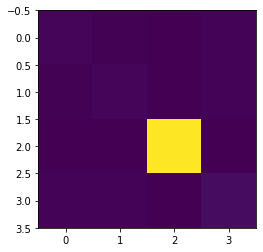

In [30]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [31]:
q = 0.5  # set risk factor
budget = num_assets // 4  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp


<QuadraticProgram: minimize 0.00017698826587336135*x_0^2 + 0.00014075005905393..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [32]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))


In [33]:

#classical reference solution

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 0.], value -0.0014

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 0]	-0.0014		1.0000
 [1 1 1 1]	9.3367		0.0000
 [0 1 1 1]	4.1663		0.0000
 [1 0 1 1]	4.1658		0.0000
 [0 0 1 1]	1.0642		0.0000
 [1 1 0 1]	4.1352		0.0000
 [0 1 0 1]	1.0334		0.0000
 [1 0 0 1]	1.0330		0.0000
 [0 0 0 1]	-0.0001		0.0000
 [1 1 1 0]	4.1649		0.0000
 [0 1 1 0]	1.0633		0.0000
 [1 0 1 0]	1.0628		0.0000
 [0 0 1 0]	0.0299		0.0000
 [1 1 0 0]	1.0320		0.0000
 [0 1 0 0]	-0.0010		0.0000
 [0 0 0 0]	1.0343		0.0000


In [34]:
##VQE SOln
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)


Optimal: selection [1. 0. 0. 0.], value -0.0014

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	-0.0010		1.0000
 [1 0 0 0]	-0.0014		0.0000
 [0 1 1 1]	4.1663		0.0000
 [0 0 0 0]	1.0343		0.0000
 [0 0 1 1]	1.0642		0.0000
 [1 0 0 1]	1.0330		0.0000
 [0 0 0 1]	-0.0001		0.0000
 [1 1 1 1]	9.3367		0.0000
 [0 1 0 1]	1.0334		0.0000
 [1 1 0 0]	1.0320		0.0000
 [0 1 1 0]	1.0633		0.0000
 [1 1 1 0]	4.1649		0.0000
 [1 0 1 1]	4.1658		0.0000
 [1 0 1 0]	1.0628		0.0000
 [0 0 1 0]	0.0299		0.0000
 [1 1 0 1]	4.1352		0.0000


In [35]:
#### QAOA solution

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)


Optimal: selection [1. 0. 0. 0.], value -0.0014

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 0]	-0.0014		0.2206
 [0 1 0 0]	-0.0010		0.2201
 [0 0 0 1]	-0.0001		0.2192
 [0 0 1 0]	0.0299		0.1901
 [0 0 0 0]	1.0343		0.0714
 [0 0 1 1]	1.0642		0.0133
 [0 1 1 0]	1.0633		0.0132
 [1 0 1 0]	1.0628		0.0132
 [1 1 0 0]	1.0320		0.0121
 [1 0 0 1]	1.0330		0.0121
 [0 1 0 1]	1.0334		0.0120
 [0 1 1 1]	4.1663		0.0007
 [1 0 1 1]	4.1658		0.0007
 [1 1 1 0]	4.1649		0.0007
 [1 1 1 1]	9.3367		0.0006
 [1 1 0 1]	4.1352		0.0001


In [36]:
stocks = ["AAPL","MSI","SSNLF","NOK"]

token = "NBQ7j3g_Q8_bcpvW6kMA"
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    try:
        wiki = WikipediaDataProvider(
            token=token,
            tickers=stocks,
            start=datetime.datetime(2016, 1, 1),
            end=datetime.datetime(2021, 12, 30),
        )
        wiki.run()
    except QiskitFinanceError as ex:
        print(ex)
        print("Error retrieving data.")


In [37]:
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        if wiki._n <= 1:
            print(
                "Not enough wiki data to plot covariance or time-series similarity. Please use at least two tickers."
            )
        else:
            rho = wiki.get_similarity_matrix()
            print("A time-series similarity measure:")
            print(rho)
            plt.imshow(rho)
            plt.show()

            cov = wiki.get_covariance_matrix()
            print("A covariance matrix:")
            print(cov)
            plt.imshow(cov)
            plt.show()
    else:
        print("No wiki data loaded.")


In [38]:
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        print("The underlying evolution of stock prices:")
        for (cnt, s) in enumerate(stocks):
            plt.plot(wiki._data[cnt], label=s)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

        for (cnt, s) in enumerate(stocks):
            print(s)
            print(wiki._data[cnt])
    else:
        print("No wiki data loaded.")


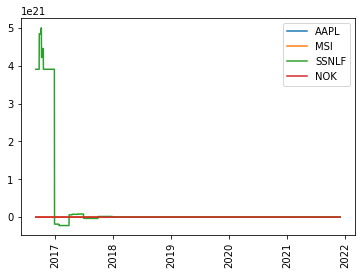

In [39]:
data = YahooDataProvider(
    tickers=["AAPL","MSI","SSNLF","NOK"],
    start=datetime.datetime(2016, 9, 1),
    end=datetime.datetime(2021, 12, 1),
  
)
data.run()
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [40]:
for (cnt, s) in enumerate(data._tickers):
    print(data._data[cnt])

Date
2016-09-01     24.919058
2016-09-02     25.152529
2016-09-06     25.145527
2016-09-07     25.299623
2016-09-08     24.636547
                 ...    
2021-11-23    160.968109
2021-11-24    161.496674
2021-11-26    156.380707
2021-11-29    159.801315
2021-11-30    164.847473
Name: Adj Close, Length: 1321, dtype: float64
Date
2016-09-01     69.213623
2016-09-02     70.250031
2016-09-06     70.583473
2016-09-07     70.367203
2016-09-08     69.727325
                 ...    
2021-11-23    254.429443
2021-11-24    258.565887
2021-11-26    250.936264
2021-11-29    256.794556
2021-11-30    250.540436
Name: Adj Close, Length: 1321, dtype: float64
Date
2016-09-01    3.910040e+21
2016-09-02    3.910040e+21
2016-09-06    3.910040e+21
2016-09-07    3.910040e+21
2016-09-08    3.910040e+21
                  ...     
2021-11-23    1.592391e+03
2021-11-24    1.592391e+03
2021-11-26    1.592391e+03
2021-11-29    1.592391e+03
2021-11-30    1.592391e+03
Name: Adj Close, Length: 1321, dtype: float64



FinTech
---



In [41]:
num_assets = 4
seed = 1234

# Generate expected return and covariance matrix from (random) time-series
#stocks = [("TICKER%s" % i) for i in range(num_assets)]
# data = RandomDataProvider(
#     tickers=stocks,
#     start=datetime.datetime(2016, 1, 1),
#     end=datetime.datetime(2016, 1, 30),
#     seed=seed,
# )



#### Using data from yahoo finance
data = YahooDataProvider(
        tickers=["JPM","GS","MS","BAC"],
        start=datetime.datetime(2017, 9, 1),
        end=datetime.datetime(2021, 12, 1),
    )
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


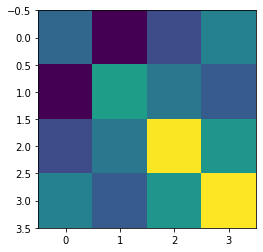

In [42]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [43]:
q = 0.5  # set risk factor
budget = num_assets // 4 # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp


<QuadraticProgram: minimize 0.00020147164313713545*x_0^2 + 0.00035607528802223..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [44]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [45]:
#classical reference solution

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 0. 1. 0.], value -0.0008

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 0 1 0]	-0.0008		1.0000
 [1 1 1 1]	9.0614		0.0000
 [0 1 1 1]	4.0266		0.0000
 [1 0 1 1]	4.0266		0.0000
 [0 0 1 1]	1.0058		0.0000
 [1 1 0 1]	4.0267		0.0000
 [0 1 0 1]	1.0060		0.0000
 [1 0 0 1]	1.0060		0.0000
 [0 0 0 1]	-0.0007		0.0000
 [1 1 1 0]	4.0266		0.0000
 [0 1 1 0]	1.0059		0.0000
 [1 0 1 0]	1.0058		0.0000
 [1 1 0 0]	1.0060		0.0000
 [0 1 0 0]	-0.0006		0.0000
 [1 0 0 0]	-0.0006		0.0000
 [0 0 0 0]	1.0068		0.0000


In [46]:
##VQE SOln
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)


Optimal: selection [0. 0. 0. 1.], value -0.0007

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	-0.0006		0.8866
 [0 0 0 1]	-0.0007		0.1075
 [1 0 0 0]	-0.0006		0.0059
 [0 0 1 0]	-0.0008		0.0000
 [1 0 1 1]	4.0266		0.0000
 [0 0 1 1]	1.0058		0.0000
 [0 1 1 0]	1.0059		0.0000
 [1 1 1 0]	4.0266		0.0000
 [1 0 1 0]	1.0058		0.0000
 [0 1 0 1]	1.0060		0.0000
 [1 1 1 1]	9.0614		0.0000
 [0 0 0 0]	1.0068		0.0000
 [1 0 0 1]	1.0060		0.0000
 [0 1 1 1]	4.0266		0.0000
 [1 1 0 0]	1.0060		0.0000
 [1 1 0 1]	4.0267		0.0000


In [47]:
#### QAOA solution

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [0. 0. 1. 0.], value -0.0008

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	-0.0006		0.2414
 [1 0 0 0]	-0.0006		0.2413
 [0 0 0 1]	-0.0007		0.2413
 [0 0 1 0]	-0.0008		0.2412
 [0 0 0 0]	1.0068		0.0136
 [1 1 0 1]	4.0267		0.0043
 [1 1 1 0]	4.0266		0.0043
 [0 1 1 1]	4.0266		0.0043
 [1 0 1 1]	4.0266		0.0043
 [0 1 0 1]	1.0060		0.0006
 [1 1 0 0]	1.0060		0.0006
 [1 0 0 1]	1.0060		0.0006
 [0 1 1 0]	1.0059		0.0006
 [0 0 1 1]	1.0058		0.0006
 [1 0 1 0]	1.0058		0.0006
 [1 1 1 1]	9.0614		0.0002


In [48]:
stocks = ["JPM","GS","SQ","MS","BAC"]

token = "NBQ7j3g_Q8_bcpvW6kMA"
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    try:
        wiki = WikipediaDataProvider(
            token=token,
            tickers=stocks,
            start=datetime.datetime(2017, 9, 1),
            end=datetime.datetime(2021, 12, 30),
        )
        wiki.run()
    except QiskitFinanceError as ex:
        print(ex)
        print("Error retrieving data.")


In [49]:
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        if wiki._n <= 1:
            print(
                "Not enough wiki data to plot covariance or time-series similarity. Please use at least two tickers."
            )
        else:
            rho = wiki.get_similarity_matrix()
            print("A time-series similarity measure:")
            print(rho)
            plt.imshow(rho)
            plt.show()

            cov = wiki.get_covariance_matrix()
            print("A covariance matrix:")
            print(cov)
            plt.imshow(cov)
            plt.show()
    else:
        print("No wiki data loaded.")

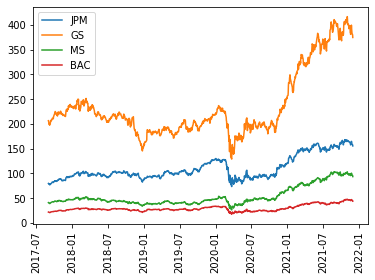

In [50]:
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        print("The underlying evolution of stock prices:")
        for (cnt, s) in enumerate(stocks):
            plt.plot(wiki._data[cnt], label=s)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

        for (cnt, s) in enumerate(stocks):
            print(s)
            print(wiki._data[cnt])
    else:
        print("No wiki data loaded.")

for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()


In [51]:
for (cnt, s) in enumerate(data._tickers):
    print(data._data[cnt])

Date
2017-09-01     79.571510
2017-09-05     77.671165
2017-09-06     78.191833
2017-09-07     76.820808
2017-09-08     76.725334
                 ...    
2021-11-23    164.590607
2021-11-24    163.299545
2021-11-26    158.379822
2021-11-29    157.695160
2021-11-30    155.347794
Name: Adj Close, Length: 1069, dtype: float64
Date
2017-09-01    206.354355
2017-09-05    198.954529
2017-09-06    199.913773
2017-09-07    197.182266
2017-09-08    198.433853
                 ...    
2021-11-23    399.392303
2021-11-24    392.364563
2021-11-26    382.732147
2021-11-29    379.930878
2021-11-30    374.475739
Name: Adj Close, Length: 1069, dtype: float64
Date
2017-09-01     40.797436
2017-09-05     39.649208
2017-09-06     39.808182
2017-09-07     38.924938
2017-09-08     38.871941
                 ...    
2021-11-23    100.293777
2021-11-24     99.565155
2021-11-26     96.424210
2021-11-29     95.734978
2021-11-30     93.362030
Name: Adj Close, Length: 1069, dtype: float64
Date
2017-09-01    21.

Retail

---



In [52]:
# set number of assets (= number of qubits)
num_assets = 4
seed = 1234

# Generate expected return and covariance matrix from (random) time-series
#stocks = [("TICKER%s" % i) for i in range(num_assets)]
# data = RandomDataProvider(
#     tickers=stocks,
#     start=datetime.datetime(2016, 1, 1),
#     end=datetime.datetime(2016, 1, 30),
#     seed=seed,
# )



#### Using data from yahoo finance
data = YahooDataProvider(
        tickers=["COST","AMZN","TGT","WMT"],
        start=datetime.datetime(2015, 9, 1),
        end=datetime.datetime(2021, 12, 1),
    )
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


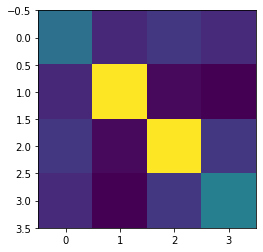

In [53]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [54]:
q = 0.5  # set risk factor
budget = num_assets // 4  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 8.437405090241747e-05*x_0^2 + 9.718516360816078e-0..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [55]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))


In [56]:

#classical reference solution

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0. 0.], value -0.0012

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	-0.0012		1.0000
 [1 1 1 1]	9.0440		0.0000
 [0 1 1 1]	4.0185		0.0000
 [1 0 1 1]	4.0189		0.0000
 [0 0 1 1]	1.0039		0.0000
 [1 1 0 1]	4.0184		0.0000
 [0 1 0 1]	1.0035		0.0000
 [1 0 0 1]	1.0038		0.0000
 [0 0 0 1]	-0.0006		0.0000
 [1 1 1 0]	4.0182		0.0000
 [0 1 1 0]	1.0032		0.0000
 [1 0 1 0]	1.0035		0.0000
 [0 0 1 0]	-0.0009		0.0000
 [1 1 0 0]	1.0031		0.0000
 [1 0 0 0]	-0.0009		0.0000
 [0 0 0 0]	1.0052		0.0000


In [57]:
##VQE SOln
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)


Optimal: selection [0. 1. 0. 0.], value -0.0012

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	-0.0012		0.9964
 [0 0 0 1]	-0.0006		0.0026
 [0 0 1 1]	1.0039		0.0007
 [1 0 0 0]	-0.0009		0.0002
 [1 0 1 0]	1.0035		0.0000
 [1 0 1 1]	4.0189		0.0000
 [0 0 1 0]	-0.0009		0.0000
 [1 1 1 1]	9.0440		0.0000
 [0 0 0 0]	1.0052		0.0000
 [0 1 1 1]	4.0185		0.0000
 [1 1 0 0]	1.0031		0.0000
 [1 1 0 1]	4.0184		0.0000
 [1 0 0 1]	1.0038		0.0000
 [1 1 1 0]	4.0182		0.0000
 [0 1 0 1]	1.0035		0.0000
 [0 1 1 0]	1.0032		0.0000


In [58]:
#### QAOA solution

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0. 0.], value -0.0012

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	-0.0012		0.2483
 [1 0 0 0]	-0.0009		0.2482
 [0 0 1 0]	-0.0009		0.2482
 [0 0 0 1]	-0.0006		0.2481
 [1 1 1 1]	9.0440		0.0040
 [0 0 0 0]	1.0052		0.0015
 [1 1 0 0]	1.0031		0.0002
 [0 1 1 0]	1.0032		0.0002
 [0 1 0 1]	1.0035		0.0002
 [1 0 1 0]	1.0035		0.0002
 [1 0 0 1]	1.0038		0.0002
 [0 0 1 1]	1.0039		0.0002
 [1 0 1 1]	4.0189		0.0001
 [0 1 1 1]	4.0185		0.0001
 [1 1 0 1]	4.0184		0.0001
 [1 1 1 0]	4.0182		0.0001


In [59]:
stocks = ["COST","AMZN","TGT","WMT"]

token = "NBQ7j3g_Q8_bcpvW6kMA"
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    try:
        wiki = WikipediaDataProvider(
            token=token,
            tickers=stocks,
            start=datetime.datetime(2015, 9, 1),
            end=datetime.datetime(2021, 12, 30),
        )
        wiki.run()
    except QiskitFinanceError as ex:
        print(ex)
        print("Error retrieving data.")

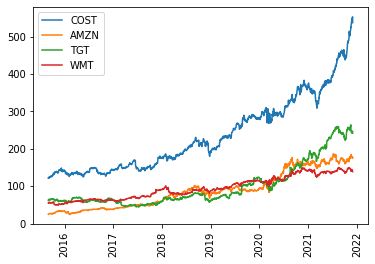

In [60]:
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        if wiki._n <= 1:
            print(
                "Not enough wiki data to plot covariance or time-series similarity. Please use at least two tickers."
            )
        else:
            rho = wiki.get_similarity_matrix()
            print("A time-series similarity measure:")
            print(rho)
            plt.imshow(rho)
            plt.show()

            cov = wiki.get_covariance_matrix()
            print("A covariance matrix:")
            print(cov)
            plt.imshow(cov)
            plt.show()
    else:
        print("No wiki data loaded.")

if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        print("The underlying evolution of stock prices:")
        for (cnt, s) in enumerate(stocks):
            plt.plot(wiki._data[cnt], label=s)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

        for (cnt, s) in enumerate(stocks):
            print(s)
            print(wiki._data[cnt])
    else:
        print("No wiki data loaded.")

for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()


In [61]:
for (cnt, s) in enumerate(data._tickers):
    print(data._data[cnt])

Date
2015-09-01    121.363937
2015-09-02    123.224350
2015-09-03    123.277023
2015-09-04    121.521904
2015-09-08    124.110641
                 ...    
2021-11-23    543.550476
2021-11-24    548.006470
2021-11-26    544.417786
2021-11-29    553.140320
2021-11-30    537.688965
Name: Adj Close, Length: 1574, dtype: float64
Date
2015-09-01     24.827000
2015-09-02     25.527500
2015-09-03     25.236000
2015-09-04     24.950001
2015-09-08     25.877001
                 ...    
2021-11-23    179.001999
2021-11-24    179.020493
2021-11-26    175.227997
2021-11-29    178.078506
2021-11-30    175.353500
Name: Adj Close, Length: 1574, dtype: float64
Date
2015-09-01     62.475933
2015-09-02     63.851570
2015-09-03     64.183067
2015-09-04     63.329498
2015-09-08     64.953751
                 ...    
2021-11-23    247.086319
2021-11-24    246.669846
2021-11-26    244.498260
2021-11-29    247.066498
2021-11-30    241.791183
Name: Adj Close, Length: 1574, dtype: float64
Date
2015-09-01     55

Healthcare

---



In [62]:
# set number of assets (= number of qubits)
num_assets = 4
seed = 1234

# Generate expected return and covariance matrix from (random) time-series
#stocks = [("TICKER%s" % i) for i in range(num_assets)]
# data = RandomDataProvider(
#     tickers=stocks,
#     start=datetime.datetime(2016, 1, 1),
#     end=datetime.datetime(2016, 1, 30),
#     seed=seed,
# )



#### Using data from yahoo finance
data = YahooDataProvider(
        tickers=["NVCR","UNH","ABT","PFE"],
        start=datetime.datetime(2016, 9, 1),
        end=datetime.datetime(2021, 12, 1),
    )
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


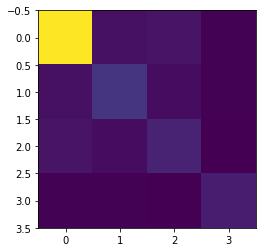

In [63]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [64]:
q = 0.5  # set risk factor
budget = num_assets // 4  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.0007473694203058352*x_0^2 + 0.000171940967430838..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [65]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [66]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 0.], value -0.0019

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 0]	-0.0019		1.0000
 [1 1 1 1]	9.0627		0.0000
 [0 1 1 1]	4.0274		0.0000
 [1 0 1 1]	4.0265		0.0000
 [0 0 1 1]	1.0060		0.0000
 [1 1 0 1]	4.0265		0.0000
 [0 1 0 1]	1.0060		0.0000
 [1 0 0 1]	1.0051		0.0000
 [0 0 0 1]	-0.0005		0.0000
 [1 1 1 0]	4.0262		0.0000
 [0 1 1 0]	1.0056		0.0000
 [1 0 1 0]	1.0048		0.0000
 [0 0 1 0]	-0.0009		0.0000
 [1 1 0 0]	1.0047		0.0000
 [0 1 0 0]	-0.0010		0.0000
 [0 0 0 0]	1.0073		0.0000


In [67]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 0.], value -0.0019

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	-0.0010		0.8845
 [0 0 0 1]	-0.0005		0.1104
 [1 0 0 0]	-0.0019		0.0050
 [0 0 1 0]	-0.0009		0.0000
 [0 0 1 1]	1.0060		0.0000
 [1 1 1 0]	4.0262		0.0000
 [1 0 1 1]	4.0265		0.0000
 [1 1 0 0]	1.0047		0.0000
 [1 0 1 0]	1.0048		0.0000
 [1 1 1 1]	9.0627		0.0000
 [0 1 0 1]	1.0060		0.0000
 [0 1 1 0]	1.0056		0.0000
 [0 1 1 1]	4.0274		0.0000
 [1 1 0 1]	4.0265		0.0000
 [0 0 0 0]	1.0073		0.0000
 [1 0 0 1]	1.0051		0.0000


In [68]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 0.], value -0.0019

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 0 0 1]	-0.0005		0.2140
 [0 0 1 0]	-0.0009		0.2138
 [0 1 0 0]	-0.0010		0.2138
 [1 0 0 0]	-0.0019		0.2133
 [0 0 0 0]	1.0073		0.0936
 [0 0 1 1]	1.0060		0.0050
 [0 1 0 1]	1.0060		0.0050
 [0 1 1 0]	1.0056		0.0050
 [1 0 0 1]	1.0051		0.0049
 [1 0 1 0]	1.0048		0.0049
 [1 1 0 0]	1.0047		0.0048
 [0 1 1 1]	4.0274		0.0048
 [1 0 1 1]	4.0265		0.0047
 [1 1 0 1]	4.0265		0.0047
 [1 1 1 0]	4.0262		0.0046
 [1 1 1 1]	9.0627		0.0030


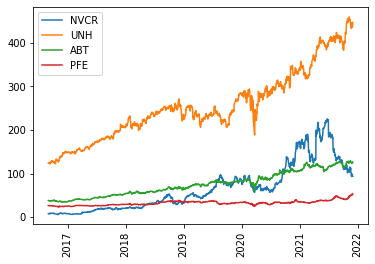

In [69]:
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        if wiki._n <= 1:
            print(
                "Not enough wiki data to plot covariance or time-series similarity. Please use at least two tickers."
            )
        else:
            rho = wiki.get_similarity_matrix()
            print("A time-series similarity measure:")
            print(rho)
            plt.imshow(rho)
            plt.show()

            cov = wiki.get_covariance_matrix()
            print("A covariance matrix:")
            print(cov)
            plt.imshow(cov)
            plt.show()
    else:
        print("No wiki data loaded.")

if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        print("The underlying evolution of stock prices:")
        for (cnt, s) in enumerate(stocks):
            plt.plot(wiki._data[cnt], label=s)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

        for (cnt, s) in enumerate(stocks):
            print(s)
            print(wiki._data[cnt])
    else:
        print("No wiki data loaded.")

for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [70]:
for (cnt, s) in enumerate(data._tickers):
    print(data._data[cnt])

Date
2016-09-01     7.750000
2016-09-02     8.050000
2016-09-06     8.040000
2016-09-07     7.960000
2016-09-08     8.510000
                ...    
2021-11-23    93.339996
2021-11-24    99.730003
2021-11-26    97.010002
2021-11-29    93.349998
2021-11-30    93.639999
Name: Adj Close, Length: 1321, dtype: float64
Date
2016-09-01    123.989174
2016-09-02    124.783859
2016-09-06    124.199272
2016-09-07    123.873505
2016-09-08    124.286446
                 ...    
2021-11-23    442.782410
2021-11-24    445.782928
2021-11-26    435.632599
2021-11-29    447.605011
2021-11-30    439.900696
Name: Adj Close, Length: 1321, dtype: float64
Date
2016-09-01     38.184296
2016-09-02     37.994732
2016-09-06     38.057919
2016-09-07     37.823219
2016-09-08     37.778076
                 ...    
2021-11-23    123.550041
2021-11-24    124.135628
2021-11-26    124.939575
2021-11-29    127.073517
2021-11-30    124.830391
Name: Adj Close, Length: 1321, dtype: float64
Date
2016-09-01    26.559505
2016


Oil
---



In [71]:
# set number of assets (= number of qubits)
num_assets = 4
seed = 1234

# Generate expected return and covariance matrix from (random) time-series
#stocks = [("TICKER%s" % i) for i in range(num_assets)]
# data = RandomDataProvider(
#     tickers=stocks,
#     start=datetime.datetime(2016, 1, 1),
#     end=datetime.datetime(2016, 1, 30),
#     seed=seed,
# )



#### Using data from yahoo finance
data = YahooDataProvider(
        tickers=["DVN","XOM","CVX","OXY"],
        start=datetime.datetime(2016, 9, 1),
        end=datetime.datetime(2021, 12, 1),
    )
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


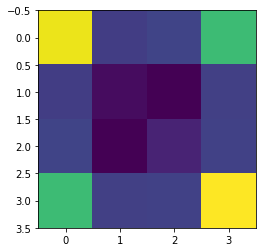

In [72]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [73]:
q = 0.5  # set risk factor
budget = num_assets // 4  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.0006360679939535736*x_0^2 + 0.000498328870938026..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [74]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [75]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 0. 1. 0.], value -0.0003

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 0 1 0]	-0.0003		1.0000
 [1 1 1 1]	9.0618		0.0000
 [0 1 1 1]	4.0275		0.0000
 [1 0 1 1]	4.0280		0.0000
 [0 0 1 1]	1.0072		0.0000
 [1 1 0 1]	4.0284		0.0000
 [0 1 0 1]	1.0076		0.0000
 [1 0 0 1]	1.0079		0.0000
 [0 0 0 1]	0.0005		0.0000
 [1 1 1 0]	4.0269		0.0000
 [0 1 1 0]	1.0066		0.0000
 [1 0 1 0]	1.0066		0.0000
 [1 1 0 0]	1.0070		0.0000
 [0 1 0 0]	0.0001		0.0000
 [1 0 0 0]	-0.0001		0.0000
 [0 0 0 0]	1.0065		0.0000


In [76]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 0.], value -0.0001

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	0.0001		0.9282
 [0 0 0 1]	0.0005		0.0593
 [1 0 0 0]	-0.0001		0.0126
 [0 0 1 1]	1.0072		0.0000
 [0 0 1 0]	-0.0003		0.0000
 [1 0 1 1]	4.0280		0.0000
 [1 1 1 0]	4.0269		0.0000
 [0 1 1 1]	4.0275		0.0000
 [1 1 1 1]	9.0618		0.0000
 [0 1 1 0]	1.0066		0.0000
 [1 1 0 0]	1.0070		0.0000
 [1 0 1 0]	1.0066		0.0000
 [1 1 0 1]	4.0284		0.0000
 [1 0 0 1]	1.0079		0.0000
 [0 0 0 0]	1.0065		0.0000
 [0 1 0 1]	1.0076		0.0000


In [77]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [0. 0. 1. 0.], value -0.0003

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 0 0 1]	0.0005		0.2411
 [1 0 0 0]	-0.0001		0.2404
 [0 1 0 0]	0.0001		0.2404
 [0 0 1 0]	-0.0003		0.2400
 [0 0 0 0]	1.0065		0.0163
 [1 1 0 1]	4.0284		0.0046
 [0 1 1 1]	4.0275		0.0046
 [1 0 1 1]	4.0280		0.0045
 [1 1 1 0]	4.0269		0.0045
 [1 0 0 1]	1.0079		0.0006
 [0 1 0 1]	1.0076		0.0006
 [0 0 1 1]	1.0072		0.0006
 [1 1 0 0]	1.0070		0.0005
 [1 0 1 0]	1.0066		0.0005
 [0 1 1 0]	1.0066		0.0005
 [1 1 1 1]	9.0618		0.0002


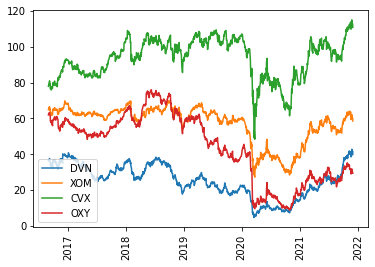

In [78]:
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        if wiki._n <= 1:
            print(
                "Not enough wiki data to plot covariance or time-series similarity. Please use at least two tickers."
            )
        else:
            rho = wiki.get_similarity_matrix()
            print("A time-series similarity measure:")
            print(rho)
            plt.imshow(rho)
            plt.show()

            cov = wiki.get_covariance_matrix()
            print("A covariance matrix:")
            print(cov)
            plt.imshow(cov)
            plt.show()
    else:
        print("No wiki data loaded.")

if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        print("The underlying evolution of stock prices:")
        for (cnt, s) in enumerate(stocks):
            plt.plot(wiki._data[cnt], label=s)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

        for (cnt, s) in enumerate(stocks):
            print(s)
            print(wiki._data[cnt])
    else:
        print("No wiki data loaded.")

for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [79]:
for (cnt, s) in enumerate(data._tickers):
    print(data._data[cnt])

Date
2016-09-01    36.312695
2016-09-02    36.786335
2016-09-06    36.736488
2016-09-07    36.728172
2016-09-08    37.625607
                ...    
2021-11-23    41.239803
2021-11-24    42.806236
2021-11-26    40.537285
2021-11-29    41.695488
2021-11-30    39.929699
Name: Adj Close, Length: 1321, dtype: float64
Date
2016-09-01    64.895439
2016-09-02    65.328857
2016-09-06    66.188278
2016-09-07    65.941643
2016-09-08    66.546951
                ...    
2021-11-23    61.804737
2021-11-24    62.147388
2021-11-26    59.964199
2021-11-29    60.297066
2021-11-30    58.583801
Name: Adj Close, Length: 1321, dtype: float64
Date
2016-09-01     77.931084
2016-09-02     78.491020
2016-09-06     79.657532
2016-09-07     80.007492
2016-09-08     80.971809
                 ...    
2021-11-23    114.152550
2021-11-24    115.026115
2021-11-26    112.395607
2021-11-29    112.729324
2021-11-30    110.785889
Name: Adj Close, Length: 1321, dtype: float64
Date
2016-09-01    61.995796
2016-09-02    6